In [7]:
# Importa bibliotecas padrão necessárias para verificar e instalar pacotes
import importlib.util  # Usado para verificar se um pacote já está instalado
import subprocess      # Usado para executar comandos do sistema (como instalar pacotes via pip)
import sys             # Permite acessar informações do sistema, como o caminho do interpretador Python

# Define uma função que instala o pacote apenas se ele ainda não estiver instalado
def instalar_se_necessario(pacote):
    if importlib.util.find_spec(pacote) is None:  # Verifica se o pacote está disponível
        subprocess.check_call([sys.executable, "-m", "pip", "install", pacote])  # Instala com pip

# Lista de pacotes necessários para o notebook funcionar corretamente
pacotes = ['pandas', 'seaborn', 'matplotlib', 'matplotlib_venn', 'openpyxl']

# Itera sobre a lista e instala os pacotes ausentes
for pacote in pacotes:
    instalar_se_necessario(pacote)

# -------------------------------------------------------------------
# IMPORTAÇÕES DAS BIBLIOTECAS NECESSÁRIAS PARA ANÁLISE E VISUALIZAÇÃO
# -------------------------------------------------------------------

# ast: usado para converter strings representando listas (por exemplo: "['A', 'B']") em listas reais
import ast

# matplotlib.pyplot: criação de gráficos
import matplotlib.pyplot as plt

# pandas: manipulação de dados em formato tabular
import pandas as pd

# seaborn: biblioteca baseada em matplotlib, com estilo estatístico aprimorado
import seaborn as sns


In [8]:

# Counter: estrutura do tipo dicionário para contar elementos (útil para frequências)
from collections import Counter

# PercentFormatter: usado para formatar eixos de gráficos em porcentagem (ex: no gráfico de Pareto)
from matplotlib.ticker import PercentFormatter

# matplotlib_venn: criação de diagramas de Venn
from matplotlib_venn import venn2

from pathlib import Path

In [9]:
# Define a raiz do projeto (2 níveis acima do notebook atual)
ROOT_DIR = Path().resolve().parent  # sai de /scripts e vai para o projeto

DATA_DIR = ROOT_DIR / "data"
SCRIPT_DIR = ROOT_DIR / "scripts"

file_path = DATA_DIR / "dados_limpos.xlsx"

df_raw = pd.read_excel(file_path)

# Exibe a quantidade total de registros (linhas) presentes no DataFrame
print(f"Total de registros: {len(df_raw)}")


Total de registros: 283


In [10]:
# Conversão de listas armazenadas como strings
for col in ['bacterias_positivas', 'bacterias_negativas', 'bacterias_inconclusivas', 'agentes_alvo', 'aplicacao', 'tipo_estudo']:
    df_raw[col] = df_raw[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
print(f"Total de registros: {len(df_raw)}")

# Garante que o campo 'ano' seja numérico
df_raw['ano'] = pd.to_numeric(df_raw['ano'], errors='coerce')

# Filtra apenas os estudos entre 2015 e 2025 (inclusive)
df = df_raw[(df_raw['ano'] >= 2015) & (df_raw['ano'] <= 2025)]
print(f"Total de registros: {len(df)}")

# Gêneros a ignorar
valores_excluir = {'', 'nan', 'NA', 'N/A', 'Não se aplica', 'Não', 'Desconhecido', '[]', 'None', 'Null'}

#Função para extrair o gênero bacteriano
def extrair_genero(b):
    if isinstance(b, str) and len(b.strip()) > 0:
        genero = b.split()[0].strip()
        if genero not in valores_excluir:
            return genero
    return None

Total de registros: 283
Total de registros: 283


In [20]:
# Exibe o número total de registros antes do pré-processamento
print(f"Total de registros antes do pré-processamento: {len(df)}")

# Remove registros duplicados com base no título do artigo
# Mantém apenas a primeira ocorrência de cada título
df_sd = df.drop_duplicates(subset='titulo', keep='first')
print(f"Total de registros após processamento de deduplicação: {len(df_sd)}")

# Extrai o gênero bacteriano de cada bactéria positiva, ignorando valores inválidos
# O resultado é uma lista com os gêneros (primeira palavra do nome binomial)
positivas = [extrair_genero(b) for sublist in df_sd['bacterias_positivas'] for b in sublist]
# Remove entradas nulas ou inválidas
positivas = [g for g in positivas if g is not None]

# Artigos com pelo menos uma bactéria positiva
artigos_positivos = df_sd[df_sd['bacterias_positivas'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
print(f"Total de artigos com bactérias positivas: {len(artigos_positivos)}")

# Faz o mesmo para bactérias negativas
negativas = [extrair_genero(b) for sublist in df_sd['bacterias_negativas'] for b in sublist]
negativas = [g for g in negativas if g is not None]

# Artigos com pelo menos uma bactéria negativa
artigos_negativos = df_sd[df_sd['bacterias_negativas'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
print(f"Total de artigos com bactérias negativas: {len(artigos_negativos)}")


# Conta a frequência de ocorrência de cada gênero positivo e negativo
count_pos = Counter(positivas)
count_neg = Counter(negativas)

# Seleciona os 15 gêneros bacterianos mais frequentes entre os positivos
top_15 = count_pos.most_common(15)
generos, frequencias = zip(*top_15)  # Separa os nomes e as contagens em listas distintas

# Exibe as estatísticas após o pré-processamento
print("############################################")
print(f"Total de registros após pré-processamento: {len(df_sd)}")

print(f"Número de gêneros bacterianos com atividade antifúngica **positiva** (distintos): {len(count_pos)}")
print(f"Número de gêneros bacterianos com atividade antifúngica **negativa** (distintos): {len(count_neg)}")
print(f"Número total de gêneros com classificação positiva ou negativa (soma simples): {len(count_pos) + len(count_neg)}")

# Alternativa mais precisa (sem duplicatas)
generos_distintos = set(count_pos.keys()) | set(count_neg.keys())
print(f"Número total de gêneros bacterianos únicos (positivos ∪ negativos): {len(generos_distintos)}")

print(f"Número de artigos com pelo menos uma bactéria positiva: {len(artigos_positivos)}")
print(f"Número de artigos com pelo menos uma bactéria negativa: {len(artigos_negativos)}")
print(f"Número total de artigos com classificação positiva ou negativa: {len(artigos_positivos) + len(artigos_negativos)}")

print("\nTop 15 gêneros bacterianos mais frequentes (atividade antifúngica positiva):")
for genero, freq in top_15:
    print(f"  - {genero}: {freq}")



Total de registros antes do pré-processamento: 283
Total de registros após processamento de deduplicação: 246
Total de artigos com bactérias positivas: 222
Total de artigos com bactérias negativas: 92
############################################
Total de registros após pré-processamento: 246
Número de gêneros bacterianos com atividade antifúngica **positiva** (distintos): 82
Número de gêneros bacterianos com atividade antifúngica **negativa** (distintos): 32
Número total de gêneros com classificação positiva ou negativa (soma simples): 114
Número total de gêneros bacterianos únicos (positivos ∪ negativos): 97
Número de artigos com pelo menos uma bactéria positiva: 222
Número de artigos com pelo menos uma bactéria negativa: 92
Número total de artigos com classificação positiva ou negativa: 314

Top 15 gêneros bacterianos mais frequentes (atividade antifúngica positiva):
  - Bacillus: 207
  - Lactobacillus: 168
  - Pseudomonas: 100
  - Streptomyces: 32
  - Paenibacillus: 22
  - Serratia:

## 1. Visualização da curadoria como indicador de rigor metodológico

curado
Sim    204
Não     42
Name: count, dtype: int64


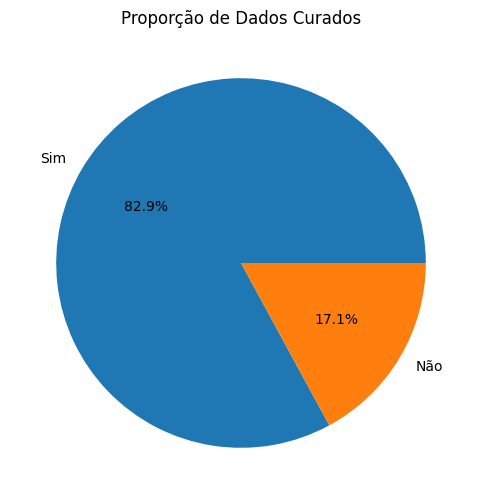

In [26]:
# Conta a quantidade de registros que possuem ou não dados curados
# A coluna 'curado' deve conter valores como True, False ou similares
curado_counts = df_sd['curado'].value_counts()
print(curado_counts)

# Gera um gráfico de pizza para visualizar a proporção entre estudos com dados curados e não curados
curado_counts.plot.pie(
    autopct='%1.1f%%',      # Mostra as porcentagens com uma casa decimal
    figsize=(6, 6),         # Define o tamanho da figura
    title='Proporção de Dados Curados'  # Título do gráfico
)

plt.ylabel('')  # Remove o rótulo padrão do eixo Y
plt.show()      # Exibe o gráfico


## . Proporção de estudos empíricos vs. revisões por ano

/tmp/ipykernel_9556/4179855597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sd['ano'] = pd.to_numeric(df_sd['ano'], errors='coerce')


246


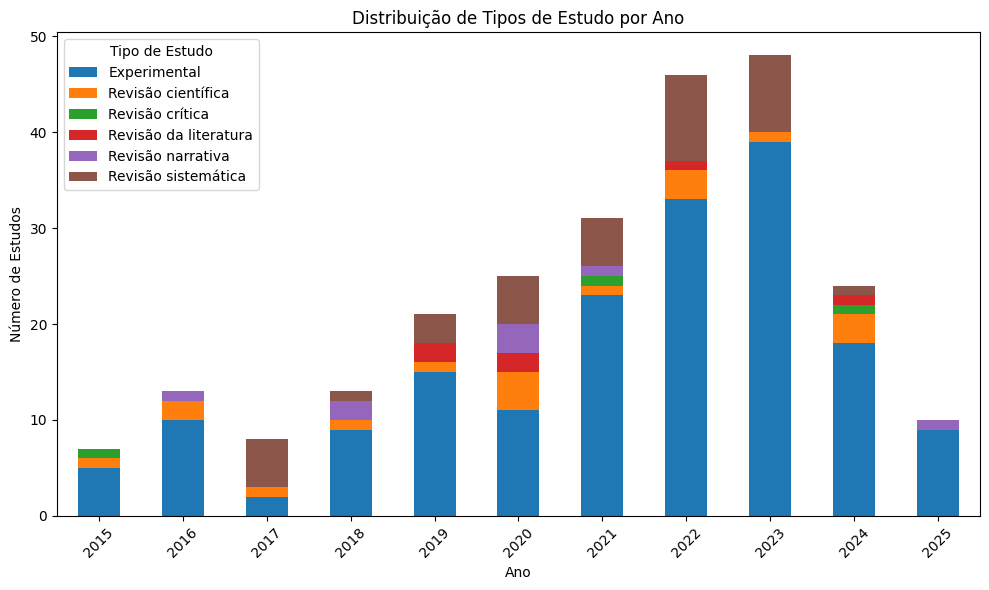

In [46]:
# Garante que a coluna 'ano' esteja no formato numérico, convertendo strings inválidas em NaN
df_sd['ano'] = pd.to_numeric(df_sd['ano'], errors='coerce')
print(len(df_sd))
# Explode a coluna 'tipo_estudo', que contém listas, para que cada tipo de estudo fique em uma linha separada
df_expl = df_sd.explode('tipo_estudo')

# Agrupa os dados por ano e tipo de estudo, contando o número de ocorrências para cada combinação
# Em seguida, reorganiza o resultado para que os tipos de estudo se tornem colunas
tipo_por_ano = df_expl.groupby(['ano', 'tipo_estudo']).size().unstack(fill_value=0)

# Plota um gráfico de barras empilhadas mostrando a distribuição dos tipos de estudo por ano
ax = tipo_por_ano.plot(kind='bar', stacked=True, figsize=(10, 6))

# Títulos e rótulos
plt.title('Distribuição de Tipos de Estudo por Ano')  # Título do gráfico
plt.xlabel('Ano')  # Rótulo do eixo X
plt.ylabel('Número de Estudos')  # Rótulo do eixo Y
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor visualização

# Atualiza o título da legenda
plt.legend(title='Tipo de Estudo')

# Ajuste de layout
plt.tight_layout()
plt.show()


## 2. Gráficos de aplicação: agrícola vs alimentícia

aplicacao
Agrícola                149
Alimentícia             109
Médica                   26
Farmacêutica             14
Cosmética                 4
Saúde humana              2
Nutrição animal           2
Avícola                   1
Saúde ambiental           1
Industria de bebidas      1
Name: count, dtype: int64


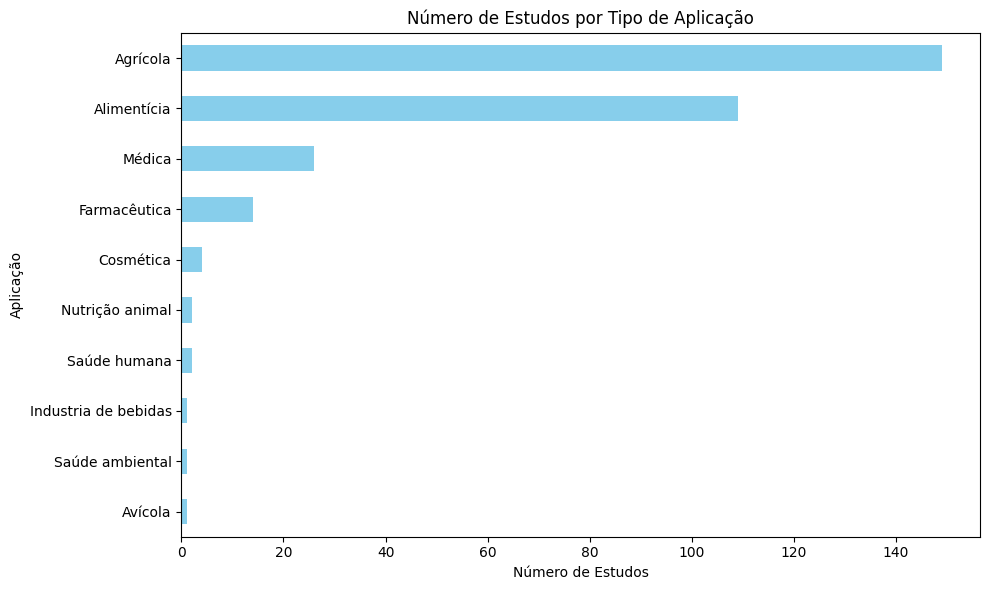

In [29]:
# --- Expansão da coluna 'aplicacao' ---
# Transforma listas de aplicações em linhas separadas para contabilização individual
df_expl_app = df_sd.explode('aplicacao')

# --- Contagem de frequência por tipo de aplicação ---
# Conta quantas vezes cada tipo de aplicação aparece no dataset
app_counts = df_expl_app['aplicacao'].value_counts().sort_values(ascending=False)
print(app_counts)

# --- Cálculo do percentual acumulado para o gráfico de Pareto ---
# Divide a soma acumulada das contagens pela soma total para obter os percentuais acumulados
cumulative = app_counts.cumsum() / app_counts.sum()

# --- Gráfico de Barras Horizontal ---
plt.figure(figsize=(10, 6))
# Ordena de forma crescente para visualização clara das aplicações menos até mais frequentes
app_counts.sort_values().plot(kind='barh', color='skyblue')
plt.title('Número de Estudos por Tipo de Aplicação')
plt.xlabel('Número de Estudos')
plt.ylabel('Aplicação')
plt.tight_layout()
plt.show()


## 3. Gráfico que precisa de um nome

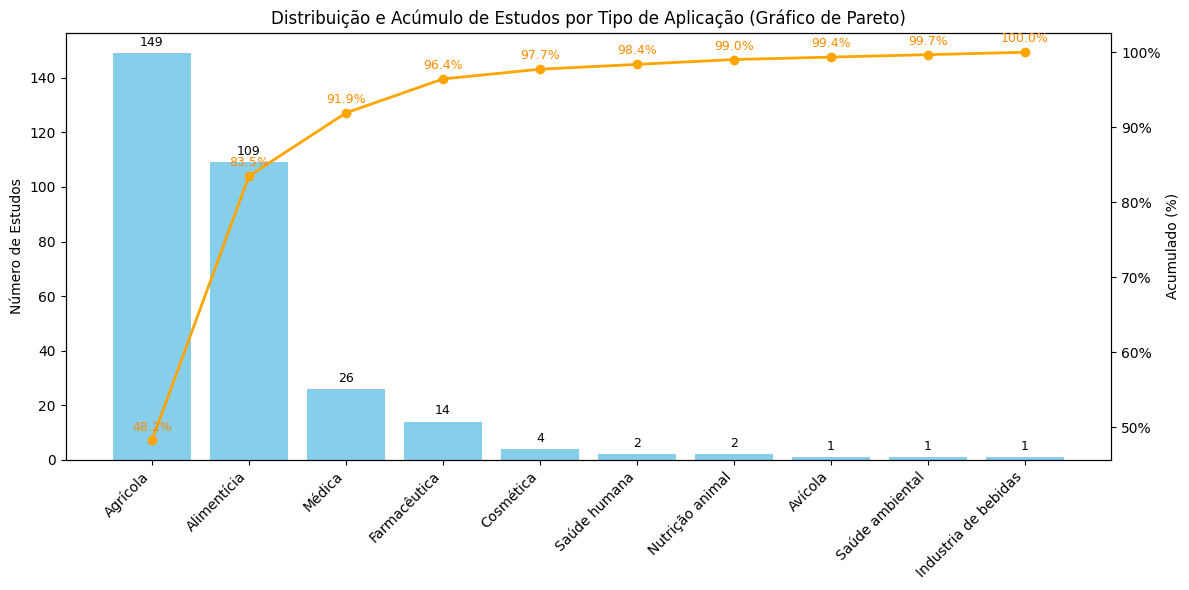

In [25]:

# --- Gráfico de Pareto com rótulos nas barras e na linha ---
# Cria um gráfico combinado com barras (frequência) e linha (percentual acumulado)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras verticais com frequência absoluta
bars = ax1.bar(app_counts.index, app_counts.values, color='skyblue')
ax1.set_ylabel("Número de Estudos")
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos para evitar sobreposição

# Adiciona valores numéricos acima de cada barra
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{int(height)}',  # Texto do valor da barra
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # Distância do valor acima da barra
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# --- Linha do acumulado percentual (eixo secundário) ---
# Adiciona um segundo eixo Y para a linha de porcentagem acumulada
ax2 = ax1.twinx()
line = ax2.plot(app_counts.index, cumulative, color='orange', marker='o', linewidth=2)
ax2.set_ylabel("Acumulado (%)")
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))  # Formata o eixo para percentual

# Adiciona rótulos percentuais nos pontos da linha
for i, (x, y) in enumerate(zip(app_counts.index, cumulative)):
    ax2.annotate(f'{y*100:.1f}%',  # Formata o valor percentual com 1 casa decimal
                 xy=(i, y),
                 xytext=(0, 5),  # Pequeno deslocamento para cima
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9, color='darkorange')

plt.title("Distribuição e Acúmulo de Estudos por Tipo de Aplicação (Gráfico de Pareto)")
plt.tight_layout()
plt.show()


## 2. Coocorrência entre bactérias e fungos

In [32]:
# --- Parâmetros de controle ---
N = 5         # Coocorrência mínima para considerar no heatmap filtrado
TOP_N = 10    # Número de gêneros bacterianos e fungos a destacar nos gráficos filtrados

# --- Função auxiliar para limpar listas (remove valores inválidos) ---
def limpar_lista(lista):
    if not isinstance(lista, list):
        return []
    return [i for i in lista if isinstance(i, str) and i.strip() not in valores_excluir]


In [33]:
# Contar artigos válidos com pelo menos uma bactéria positiva e um agente alvo
artigos_cooc = df_sd[df_sd.apply(lambda row: isinstance(row.get('bacterias_positivas'), list) and
                                         isinstance(row.get('agentes_alvo'), list) and
                                         len(row.get('bacterias_positivas')) > 0 and
                                         len(row.get('agentes_alvo')) > 0, axis=1)]
print(f"Total de artigos usados para o gráfico de coocorrência: {len(artigos_cooc)}")

# --- Construção do dicionário de coocorrência bactéria x fungo ---
cooc = {}
for _, row in df_sd.iterrows():
    bact_list = limpar_lista(row.get('bacterias_positivas', []))
    fungos_list = limpar_lista(row.get('agentes_alvo', []))
    
    for b in bact_list:
        gen = extrair_genero(b)
        if not gen:
            continue
        for f in fungos_list:
            pair = (gen, f.strip())
            cooc[pair] = cooc.get(pair, 0) + 1


Total de artigos usados para o gráfico de coocorrência: 222


In [35]:
# --- Conversão do dicionário para DataFrame ---
cooc_df = pd.DataFrame.from_dict(cooc, orient='index', columns=['freq'])
print(f"Total de artigos: {len(cooc )}")

# Verifica se há dados para análise
if not cooc_df.empty:
    cooc_df.reset_index(inplace=True)
    cooc_df[['bacteria', 'fungus']] = pd.DataFrame(cooc_df['index'].tolist(), index=cooc_df.index)
else:
    print("⚠️ Nenhuma coocorrência válida encontrada.")


Total de artigos: 1636


/tmp/ipykernel_9556/3750065974.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bact_mais_frequentes.values, y=bact_mais_frequentes.index, palette='flare')


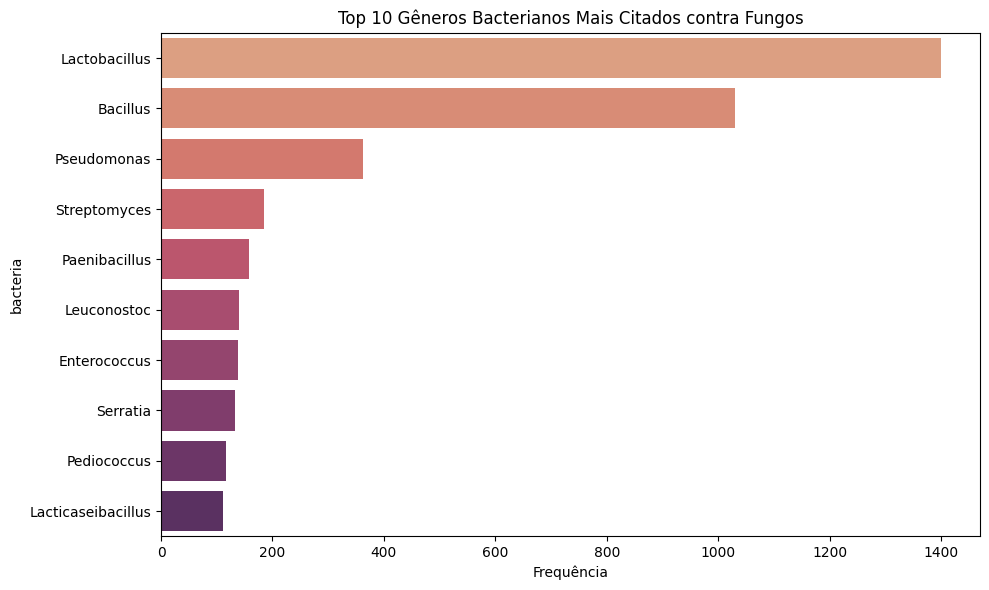

In [36]:
# --- Gráfico de barras: Top 10 Gêneros Bacterianos ---
bact_mais_frequentes = cooc_df.groupby('bacteria')['freq'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=bact_mais_frequentes.values, y=bact_mais_frequentes.index, palette='flare')
plt.xlabel('Frequência')
plt.title('Top 10 Gêneros Bacterianos Mais Citados contra Fungos')
plt.tight_layout()
plt.show()

## alguna cosa

/tmp/ipykernel_9556/658721771.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(generos), y=list(frequencias), palette="crest")


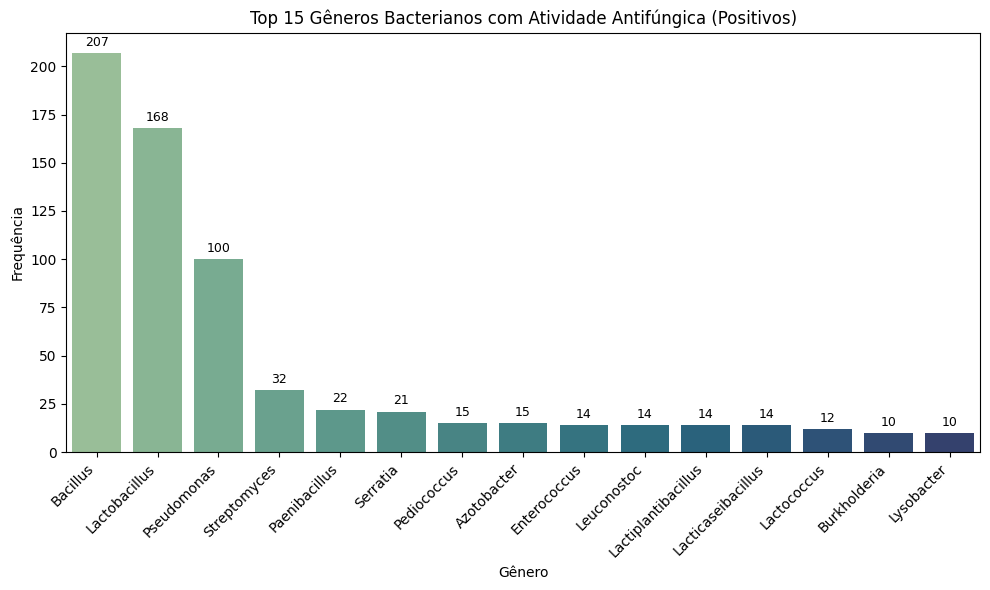

In [47]:
# === Gráfico de Barras para os 15 gêneros bacterianos positivos mais frequentes ===
plt.figure(figsize=(10, 6))

# Cria o gráfico de barras com cores personalizadas (palette "crest")
ax = sns.barplot(x=list(generos), y=list(frequencias), palette="crest")

# Ajusta a rotação e alinhamento dos rótulos no eixo X para melhor leitura
plt.xticks(rotation=45, ha='right', fontsize=10)

# Define título e rótulos dos eixos
plt.title('Top 15 Gêneros Bacterianos com Atividade Antifúngica (Positivos)')
plt.xlabel('Gênero')
plt.ylabel('Frequência')

# Adiciona rótulos numéricos no topo de cada barra (valor da frequência)
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.annotate(f'{int(height)}',  # valor inteiro da barra
                xy=(bar.get_x() + bar.get_width() / 2, height),  # posição central no topo
                xytext=(0, 3),  # desloca levemente o texto acima da barra
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()  # Ajusta o layout para evitar cortes de textos
plt.show()

## alguma coisa bla bla

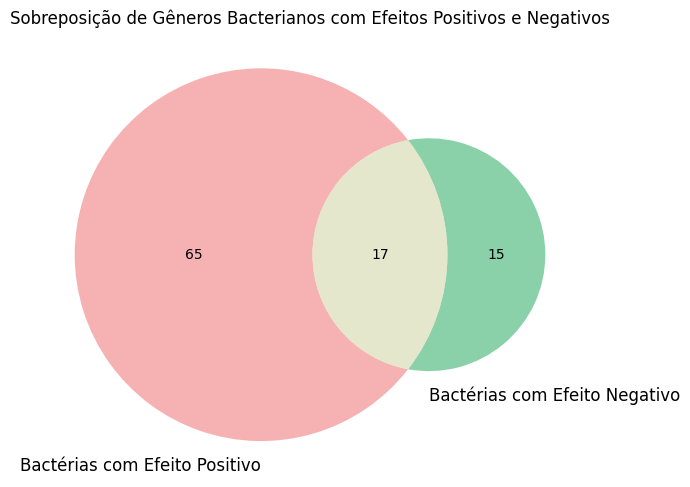

In [49]:

plt.figure(figsize=(7, 6))

# Cria o diagrama de Venn comparando os conjuntos de gêneros positivos e negativos
venn2([set(positivas), set(negativas)],
       set_labels=('Bactérias com Efeito Positivo', 'Bactérias com Efeito Negativo'),
       set_colors=('lightcoral', 'mediumseagreen'),
       alpha=0.6)

plt.title('Sobreposição de Gêneros Bacterianos com Efeitos Positivos e Negativos')
plt.show()

## 5. Evolução de publicações e emergência de gêneros ao longo dos anos

/tmp/ipykernel_9556/1388757612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sd['bacterias_genero'] = df_sd['bacterias_positivas'].apply(


bacterias_genero
Bacillus           207
Lactobacillus      168
Pseudomonas        100
Streptomyces        32
Paenibacillus       22
                  ... 
Acetobacter          1
Wickerhamomyces      1
Epichloë             1
Aeribacillus         1
Brevibacterium       1
Name: count, Length: 82, dtype: int64
bacterias_genero  Azotobacter  Bacillus  Burkholderia  Enterococcus  \
ano                                                                   
2015                        0         1             0             0   
2016                        0        14             1             0   
2017                        0         6             0             0   
2018                        0        13             0             1   
2019                        0         9             2             1   
2020                        0        24             2             1   
2021                        0        33             3             3   
2022                        8        34             2

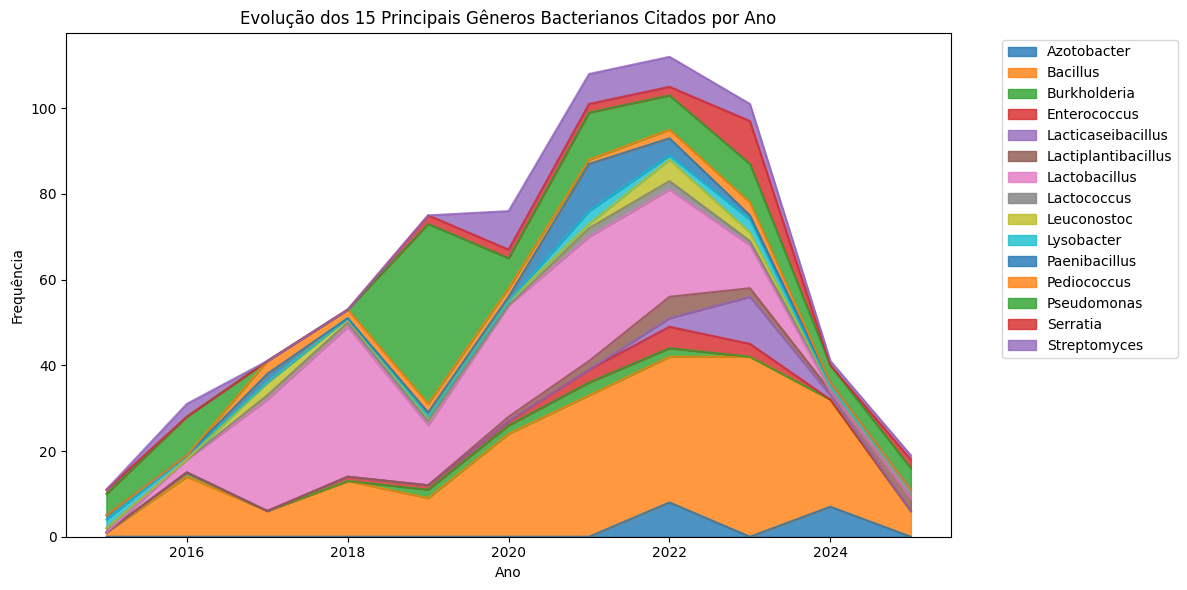

In [50]:
# Criar coluna com o gênero bacteriano (primeira palavra)
df_sd['bacterias_genero'] = df_sd['bacterias_positivas'].apply(
    lambda lst: [b.split()[0] for b in lst if isinstance(b, str) and b.strip()]
)

# Explodir a coluna de listas
df_expl_genero = df_sd.explode('bacterias_genero')

# Remover valores inválidos
valores_invalidos = ['Não', 'Nao', 'NA', None, '', 'nan']
df_expl_genero = df_expl_genero[~df_expl_genero['bacterias_genero'].isin(valores_invalidos)]

# Agrupar por gênero
genero_total = df_expl_genero['bacterias_genero'].value_counts()
print(genero_total)

# Selecionar os 15 mais frequentes
top_generos = genero_total.head(15).index

# Filtrar apenas os registros com os top 15 gêneros
df_top = df_expl_genero[df_expl_genero['bacterias_genero'].isin(top_generos)]

# Agrupar por ano e gênero
genero_ano_top = df_top.groupby(['ano', 'bacterias_genero']).size().unstack(fill_value=0)
print(genero_ano_top)
# Plot
genero_ano_top.plot.area(figsize=(12, 6), alpha=0.8)
plt.title('Evolução dos 15 Principais Gêneros Bacterianos Citados por Ano')
plt.xlabel('Ano')
plt.ylabel('Frequência')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### alguma aqui

/tmp/ipykernel_9556/4139604154.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fungos_mais_frequentes.values, y=fungos_mais_frequentes.index, palette='crest')


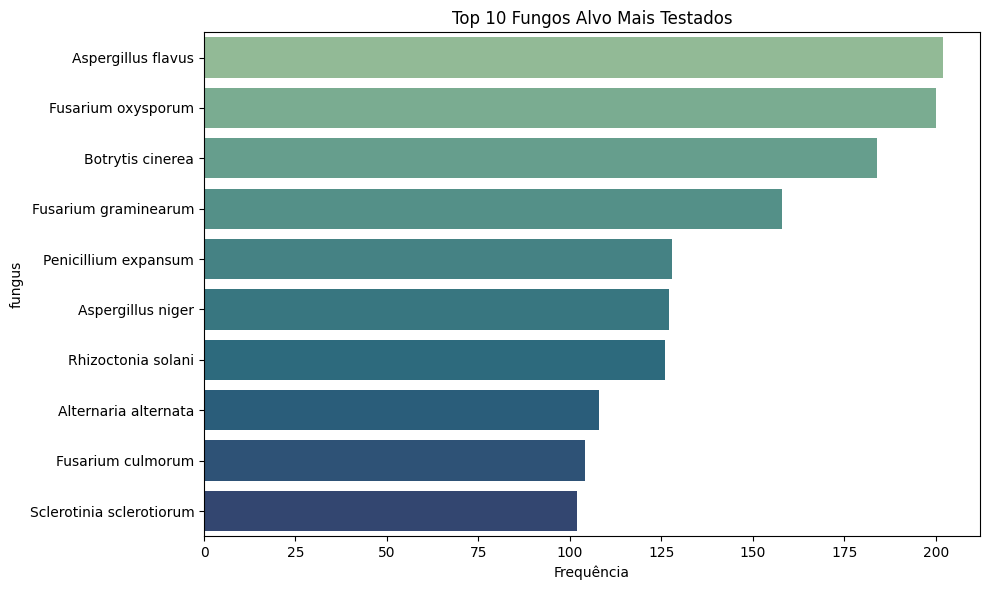

In [40]:
# --- Gráfico de barras: Top 10 Fungos Mais Testados ---
fungos_mais_frequentes = cooc_df.groupby('fungus')['freq'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=fungos_mais_frequentes.values, y=fungos_mais_frequentes.index, palette='crest')
plt.xlabel('Frequência')
plt.title('Top 10 Fungos Alvo Mais Testados')
plt.tight_layout()
plt.show()


## alguma coisa

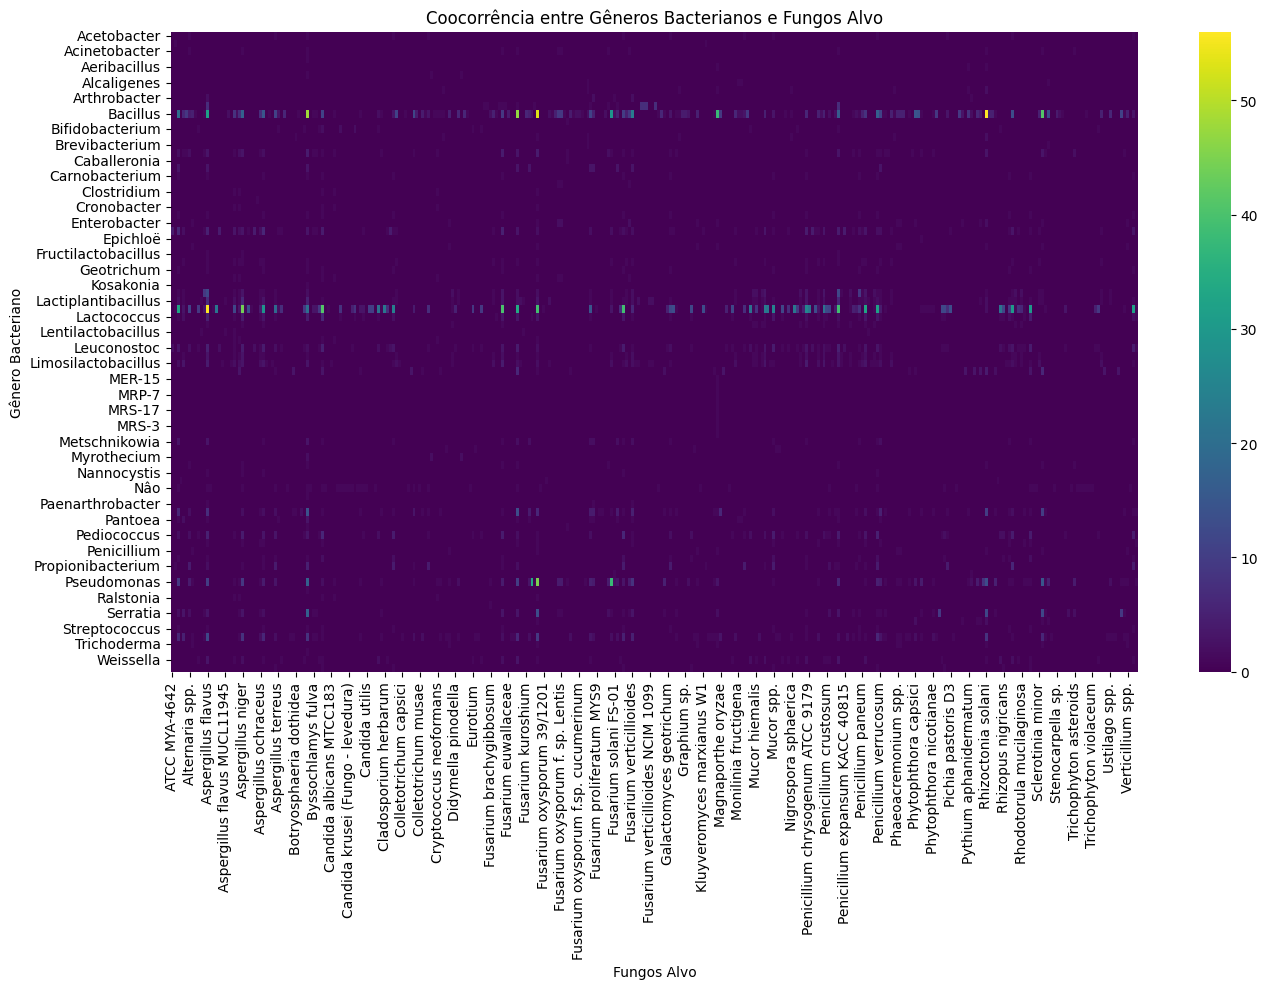

In [41]:
# --- Heatmap completo com todos os pares válidos ---
pivot = cooc_df.pivot(index='bacteria', columns='fungus', values='freq').fillna(0)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot, cmap='viridis')
plt.title('Coocorrência entre Gêneros Bacterianos e Fungos Alvo')
plt.xlabel('Fungos Alvo')
plt.ylabel('Gênero Bacteriano')
plt.tight_layout()
plt.show()


## alguma coisa

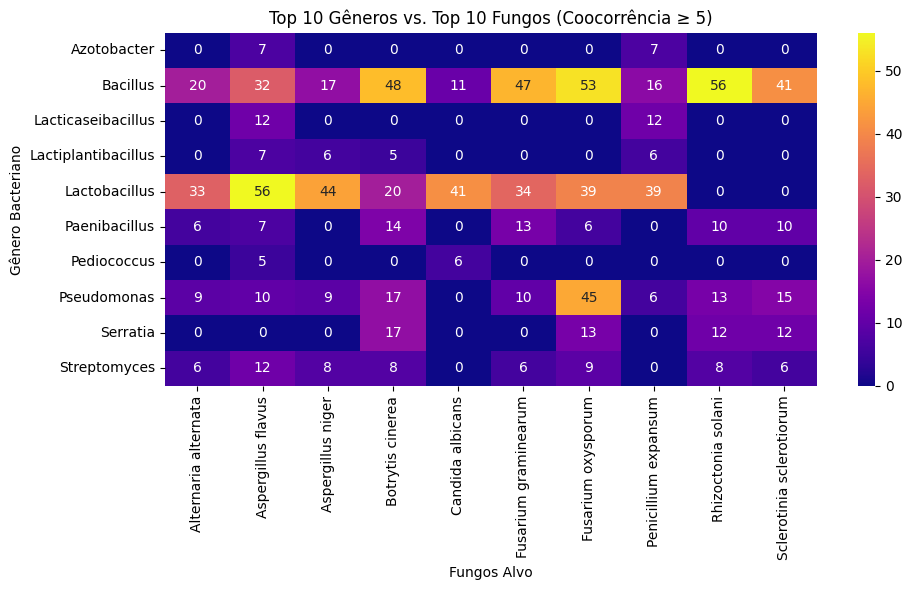

In [42]:
# --- Filtra pares com coocorrência ≥ N ---
cooc_df_filtrada = cooc_df[cooc_df['freq'] >= N]

# Seleciona os TOP gêneros e fungos
top_bact = cooc_df_filtrada.groupby('bacteria')['freq'].sum().sort_values(ascending=False).head(TOP_N).index
top_fung = cooc_df_filtrada.groupby('fungus')['freq'].sum().sort_values(ascending=False).head(TOP_N).index

# Filtra os dados para o heatmap anotado
cooc_top = cooc_df_filtrada[cooc_df_filtrada['bacteria'].isin(top_bact) & cooc_df_filtrada['fungus'].isin(top_fung)]
pivot_top = cooc_top.pivot(index='bacteria', columns='fungus', values='freq').fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_top, cmap='plasma', annot=True, fmt=".0f", annot_kws={"size": 10})
plt.title(f'Top {TOP_N} Gêneros vs. Top {TOP_N} Fungos (Coocorrência ≥ {N})')
plt.xlabel('Fungos Alvo')
plt.ylabel('Gênero Bacteriano')
plt.tight_layout()
plt.show()
